In [1]:
# dataset: healthcare-dataset-stroke-data.csv
# taken from kaggle. 
# url: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download&select=healthcare-dataset-stroke-data.csv

# binary classification problem
# given a sety of featurs, determine the probability of stroke.




In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import auc
from tqdm.auto import tqdm
import xgboost as xgb

from sklearn.utils import shuffle


In [130]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', header=0)
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [131]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [133]:
df = df.rename(columns={'Residence_type':'residence_type'})

In [134]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [135]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [136]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [137]:
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [138]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [139]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [140]:
#we'll treat 'unknown' as another category of the smk_status, even if it's a non-information bearing category

<AxesSubplot:>

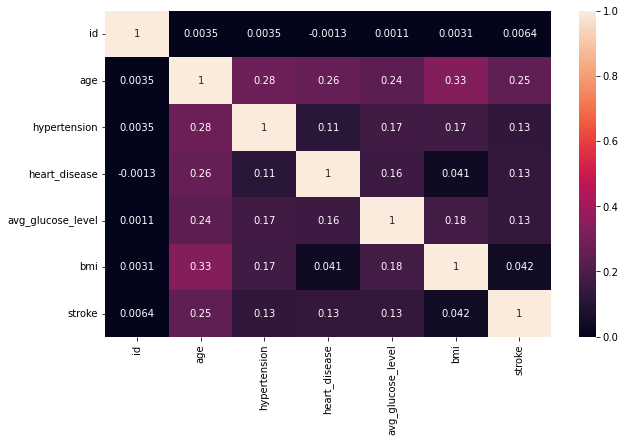

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [142]:
#correlation only applies to numeric values. Among these looks like bmi alone seems to have a low correlation with stroke

In [143]:
#let's turn to a way to convert categorical columns to number in order to have a complete correlation matrix.
categorical = ['gender','ever_married','work_type', 'residence_type','smoking_status']

df[categorical]


,gender,ever_married,work_type,residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [144]:
df['residence_type']


0       Urban
1       Rural
2       Rural
3       Urban
4       Rural
        ...  
5105    Urban
5106    Urban
5107    Rural
5108    Rural
5109    Urban
Name: residence_type, Length: 5110, dtype: object

In [145]:
from sklearn.preprocessing import LabelEncoder
labenc=LabelEncoder()
gender=labenc.fit_transform(df['gender'])
work_type = labenc.fit_transform(df['work_type'])
ever_married = labenc.fit_transform(df['ever_married'])
residence_type = labenc.fit_transform(df['residence_type'])
smoking_status = labenc.fit_transform(df['smoking_status'])


df['gender'] = gender
df['work_type'] = work_type
df['ever_married'] = ever_married
df['residence_type'] = residence_type
df['smoking_status'] = smoking_status




In [146]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,NaN,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


<AxesSubplot:>

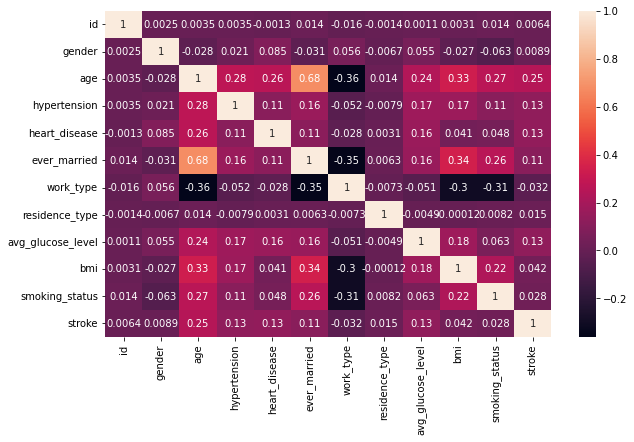

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [148]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

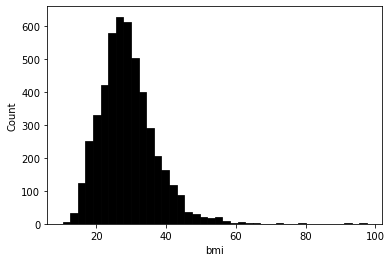

In [149]:
#how is bmi construed / distrbibuted?

%matplotlib inline

plt.figure(figsize=(6, 4))

sns.histplot(df.bmi, bins=40, color='black', alpha=1)

In [150]:
df['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [151]:
df['bmi'].fillna(df['bmi'].mean(),inplace=True)


In [152]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

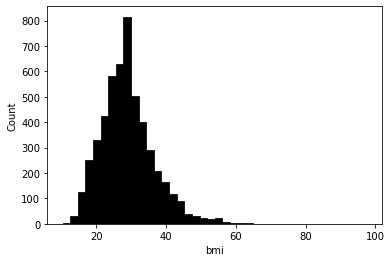

In [153]:

%matplotlib inline

plt.figure(figsize=(6, 4))

sns.histplot(df.bmi, bins=40, color='black', alpha=1)

<AxesSubplot:>

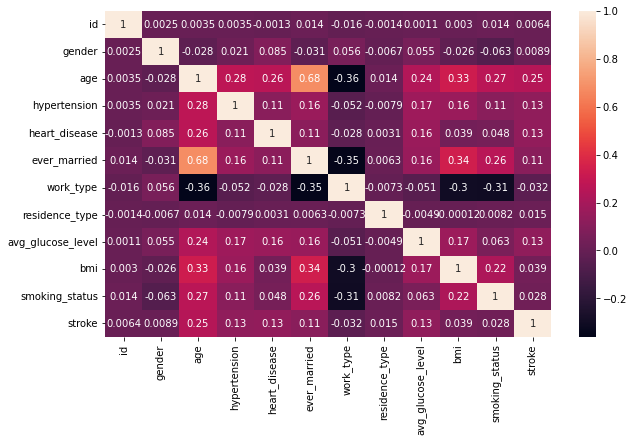

In [154]:
#did the correlation change?
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [155]:
#bmi correlation decreased. [after normalizing with the mean]
#highest correlation seems to be age
#lowest (i absolute terms) seems to be gender 

In [218]:
#MODEL TRAINING
df = pd.read_csv('healthcare-dataset-stroke-data.csv', header=0)
df['bmi'].fillna(df['bmi'].mean(),inplace=True)

# inserted ot test a randomization on the dataset.
#removed for reproducibility purposes
#df = shuffle(df)

df = df.drop(columns='id')

y_prep = df.stroke
df_prep = df.drop(columns='stroke')

#build train and validation set with sklearn
# random state for reproducibility of the test.

df_train_full, df_test = train_test_split(df_prep, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

y_train_full, y_test = train_test_split(y_prep, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(y_train_full, test_size=0.25, random_state=42)

import warnings   
#warnings.filterwarnings('ignore')


# one hot encoding of the categorical values

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

scores = []

# model_1 : logistic regression
# optimization of model_1 on the solver algo and the C variable
# no variation in the penalty choice, so that the default l2 is used for every iteration

for solver_var in tqdm(['newton-cg','lbfgs','liblinear','sag','saga']):
    for c_var in tqdm([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):

        model = LogisticRegression(solver=solver_var, C=c_var, max_iter=1000 ,random_state=42)
        model.fit(X_train, y_train)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

        print('solver=%s C=%s aucvalue: %.3f +- %.3f' % (solver_var, c_var, np.mean(scores), np.std(scores)))
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

solver=newton-cg C=0.001 aucvalue: 0.831 +- 0.000
solver=newton-cg C=0.01 aucvalue: 0.831 +- 0.000
solver=newton-cg C=0.1 aucvalue: 0.832 +- 0.001
solver=newton-cg C=1 aucvalue: 0.833 +- 0.001
solver=newton-cg C=10 aucvalue: 0.833 +- 0.002
solver=newton-cg C=100 aucvalue: 0.834 +- 0.002
solver=newton-cg C=1000 aucvalue: 0.834 +- 0.002
solver=newton-cg C=10000 aucvalue: 0.834 +- 0.002


  0%|          | 0/8 [00:00<?, ?it/s]

solver=lbfgs C=0.001 aucvalue: 0.834 +- 0.002
solver=lbfgs C=0.01 aucvalue: 0.833 +- 0.002
solver=lbfgs C=0.1 aucvalue: 0.833 +- 0.002
solver=lbfgs C=1 aucvalue: 0.834 +- 0.002
solver=lbfgs C=10 aucvalue: 0.834 +- 0.002
solver=lbfgs C=100 aucvalue: 0.834 +- 0.002
solver=lbfgs C=1000 aucvalue: 0.834 +- 0.002
solver=lbfgs C=10000 aucvalue: 0.834 +- 0.002


  0%|          | 0/8 [00:00<?, ?it/s]

solver=liblinear C=0.001 aucvalue: 0.823 +- 0.046
solver=liblinear C=0.01 aucvalue: 0.815 +- 0.055
solver=liblinear C=0.1 aucvalue: 0.814 +- 0.054
solver=liblinear C=1 aucvalue: 0.814 +- 0.052
solver=liblinear C=10 aucvalue: 0.815 +- 0.051
solver=liblinear C=100 aucvalue: 0.816 +- 0.050
solver=liblinear C=1000 aucvalue: 0.817 +- 0.049
solver=liblinear C=10000 aucvalue: 0.818 +- 0.048


  0%|          | 0/8 [00:00<?, ?it/s]

solver=sag C=0.001 aucvalue: 0.814 +- 0.052
solver=sag C=0.01 aucvalue: 0.810 +- 0.054
solver=sag C=0.1 aucvalue: 0.808 +- 0.054
solver=sag C=1 aucvalue: 0.807 +- 0.053
solver=sag C=10 aucvalue: 0.806 +- 0.053
solver=sag C=100 aucvalue: 0.805 +- 0.052
solver=sag C=1000 aucvalue: 0.804 +- 0.052
solver=sag C=10000 aucvalue: 0.803 +- 0.051


  0%|          | 0/8 [00:00<?, ?it/s]

solver=saga C=0.001 aucvalue: 0.799 +- 0.055
solver=saga C=0.01 aucvalue: 0.796 +- 0.057
solver=saga C=0.1 aucvalue: 0.794 +- 0.057
solver=saga C=1 aucvalue: 0.792 +- 0.058
solver=saga C=10 aucvalue: 0.790 +- 0.058
solver=saga C=100 aucvalue: 0.788 +- 0.058
solver=saga C=1000 aucvalue: 0.787 +- 0.058
solver=saga C=10000 aucvalue: 0.785 +- 0.058


In [157]:
# best combination of solver and C factor for logistic regression:
# solver=lbfgs aucvalue: 0.834 +- 0.002


In [219]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))


|--- age <= 67.50
|   |--- value: [0.02]
|--- age >  67.50
|   |--- value: [0.17]



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

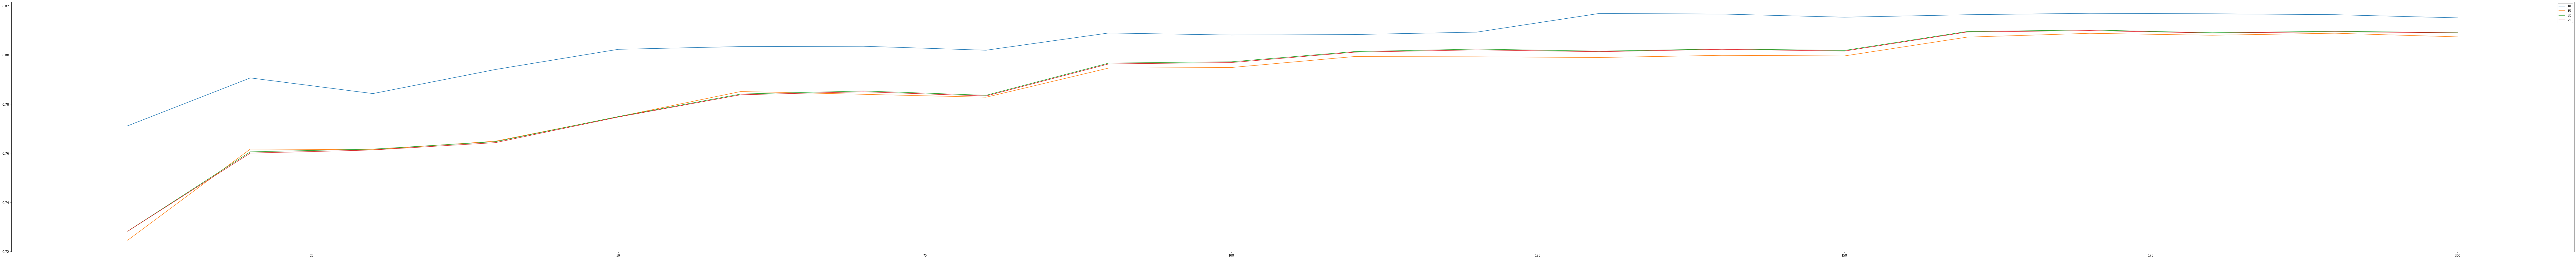

In [220]:
# this is just to confirm that the correlation matrix we found has some solid confirmation in this.
# the DTregressor finds as a first discriminating feature the age, which had the maximum correlation in the corr matrix.

# model_2 : Random forest
# optimization of model_2 on the number of estimators, min leaf, and 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

scores = []
scores_auc = []

#cicla tra le varie depth dell'albero:

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, 
                               n_jobs=-1)
#per ogni depth, cicla tra tutti i numero estimatori
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
#calcola l'errore per la combo depth/estimatori e la appende
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        score_auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, score))
        scores_auc.append((d, n, score_auc))

        
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
#a fine ciclo crea il dataframe (utile per la visualizzazione)

columns2 = ['max_depth', 'n_estimators', 'auc']
df_scores2 = pd.DataFrame(scores_auc, columns=columns2)
#a fine ciclo crea il dataframe (utile per la visualizzazione)


# crea grafico. colori diversi per depth diverse.
#for d in [10, 15, 20, 25]:
#    df_subset = df_scores[df_scores.max_depth == d]
#    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

#plt.legend()


for d in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=d)

plt.legend()




In [221]:
df_subset = df_scores2[df_scores2.max_depth == 10]
df_subset


,max_depth,n_estimators,auc
0,10,10,0.771147
1,10,20,0.790644
2,10,30,0.784265
3,10,40,0.794083
4,10,50,0.802287
5,10,60,0.803414
6,10,70,0.803542
7,10,80,0.801926
8,10,90,0.808933
9,10,100,0.808108


In [223]:
#max auc= 0.81695 is reached with max_depth = 10, n_estimators = 170 

#model_3: xgboost
import xgboost as xgb

features = dv.get_feature_names()
#check that the feature names comply with xgb requirements

features


['Residence_type=Rural',
 'Residence_type=Urban',
 'age',
 'avg_glucose_level',
 'bmi',
 'ever_married=No',
 'ever_married=Yes',
 'gender=Female',
 'gender=Male',
 'heart_disease',
 'hypertension',
 'smoking_status=Unknown',
 'smoking_status=formerly smoked',
 'smoking_status=never smoked',
 'smoking_status=smokes',
 'work_type=Govt_job',
 'work_type=Never_worked',
 'work_type=Private',
 'work_type=Self-employed',
 'work_type=children']

In [224]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


scores = {}



In [225]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)




def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results





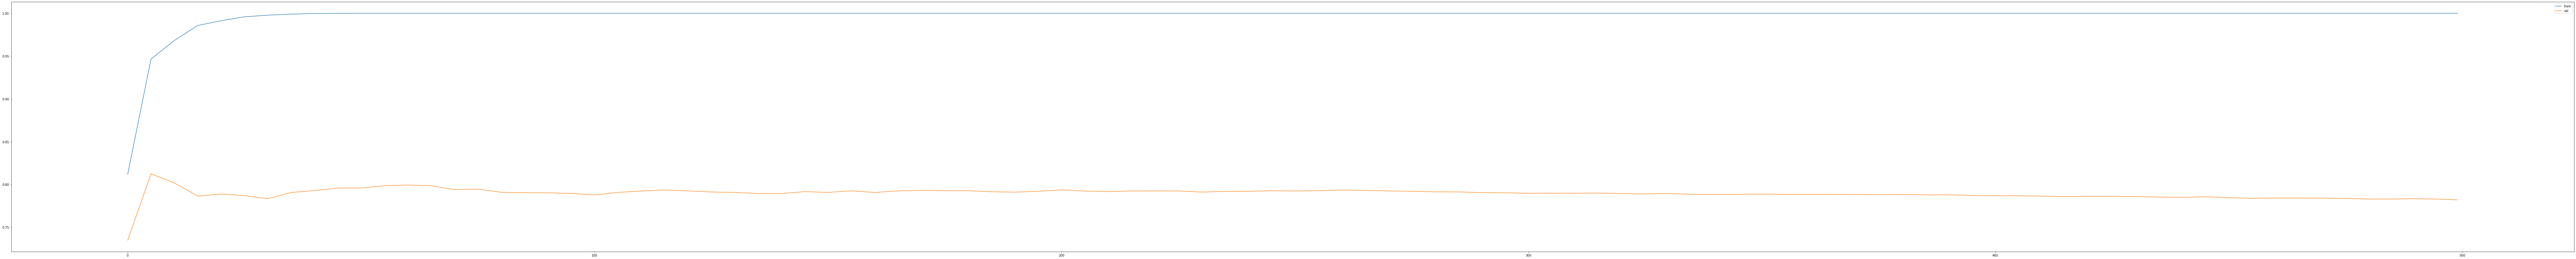

In [226]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()



In [227]:
%%capture output
#let's tune the depth.

#variable max depth: [1, 2, 4, 8, 10, 15, 20]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)

scores['depth=20'] = parse_xgb_output(output)



In [228]:
scores

{'depth=20':      num_iter  train_auc  val_auc
 0           0    0.81190  0.73483
 1           5    0.94663  0.81248
 2          10    0.96826  0.80176
 3          15    0.98577  0.78640
 4          20    0.99127  0.78891
 5          25    0.99589  0.78693
 6          30    0.99784  0.78349
 7          35    0.99902  0.79060
 8          40    0.99976  0.79288
 9          45    0.99999  0.79578
 10         50    1.00000  0.79587
 11         55    1.00000  0.79859
 12         60    1.00000  0.79934
 13         65    1.00000  0.79852
 14         70    1.00000  0.79390
 15         75    1.00000  0.79457
 16         80    1.00000  0.79088
 17         85    1.00000  0.79041
 18         90    1.00000  0.79023
 19         95    1.00000  0.78953
 20        100    1.00000  0.78776
 21        105    1.00000  0.79076
 22        110    1.00000  0.79232
 23        115    1.00000  0.79348
 24        120    1.00000  0.79248
 25        125    1.00000  0.79123
 26        130    1.00000  0.79069
 27     

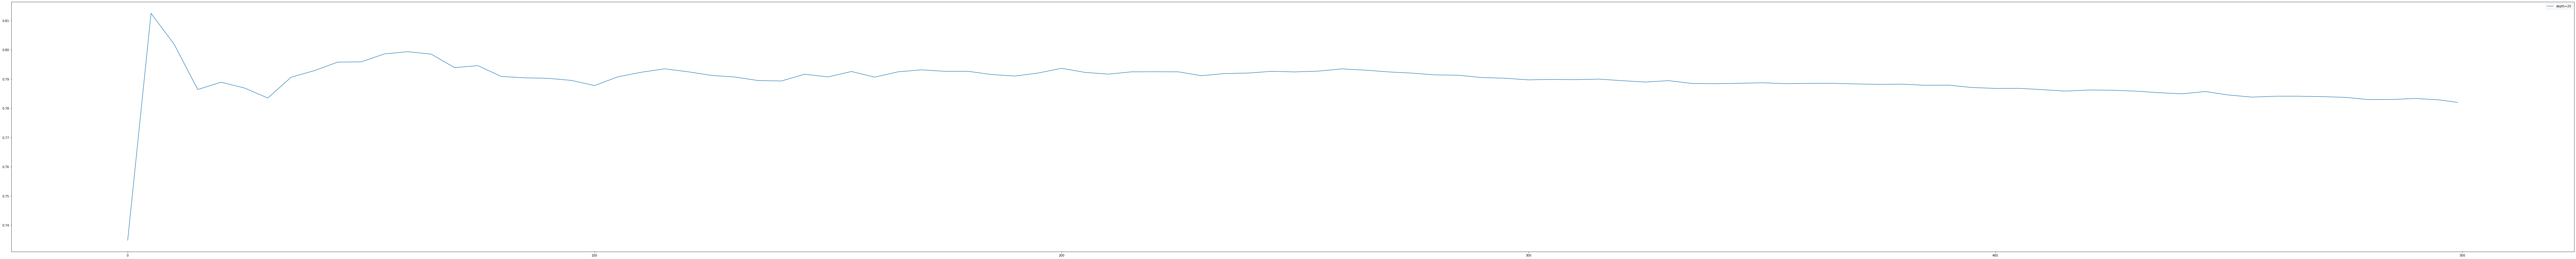

In [229]:


for depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=depth)

plt.legend()



In [230]:
pd.options.display.max_seq_items = 200
pd.set_option('display.max_rows', 1000)


In [231]:
#best max_depth is 2
#let's find the best eta within this
scores2 = {}

In [232]:
%%capture output
#let's tune the eta.

#variable eta: [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

xgb_params = {
    'eta':1, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)

scores2['eta=1'] = parse_xgb_output(output)

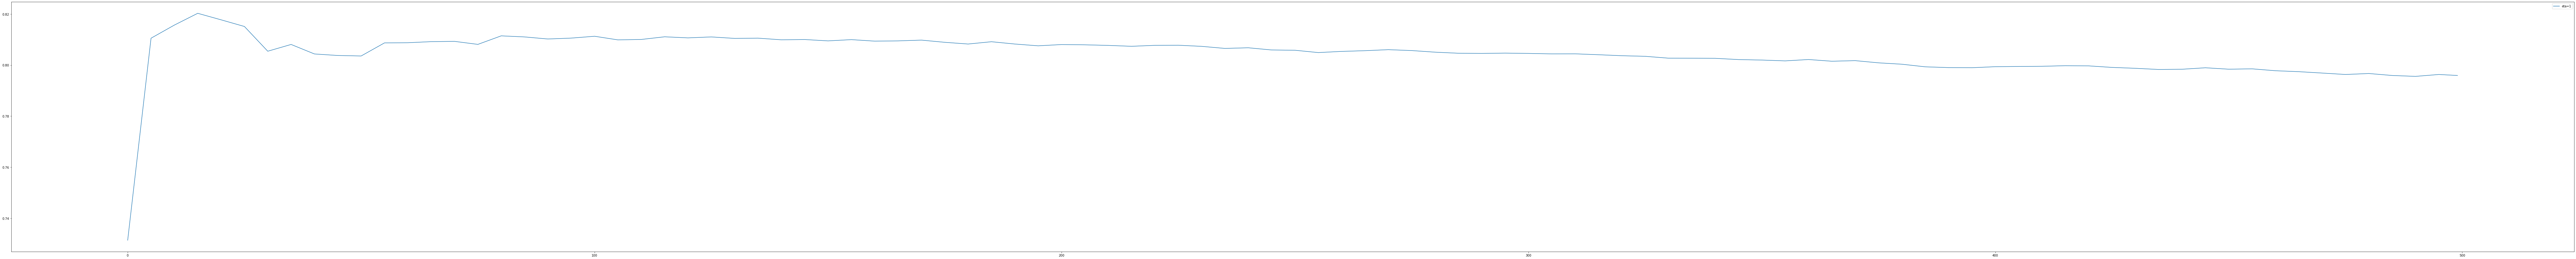

In [233]:
for eta, df_score in scores2.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()


In [234]:
#at 500 iterations, the best eta is 0.05 auc = .83792

scores3 = {}



In [235]:
%%capture output
#let's tune the min_child_weight.

# eta = 0.05
# max_depth = 2
# min_child_weight =

#variable m_c_w: [1, 2, 5, 10, 20, 25]

xgb_params = {
    'eta': 0.05, 
    'max_depth': 2,
    'min_child_weight': 25,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)

scores3['mcw=25'] = parse_xgb_output(output)


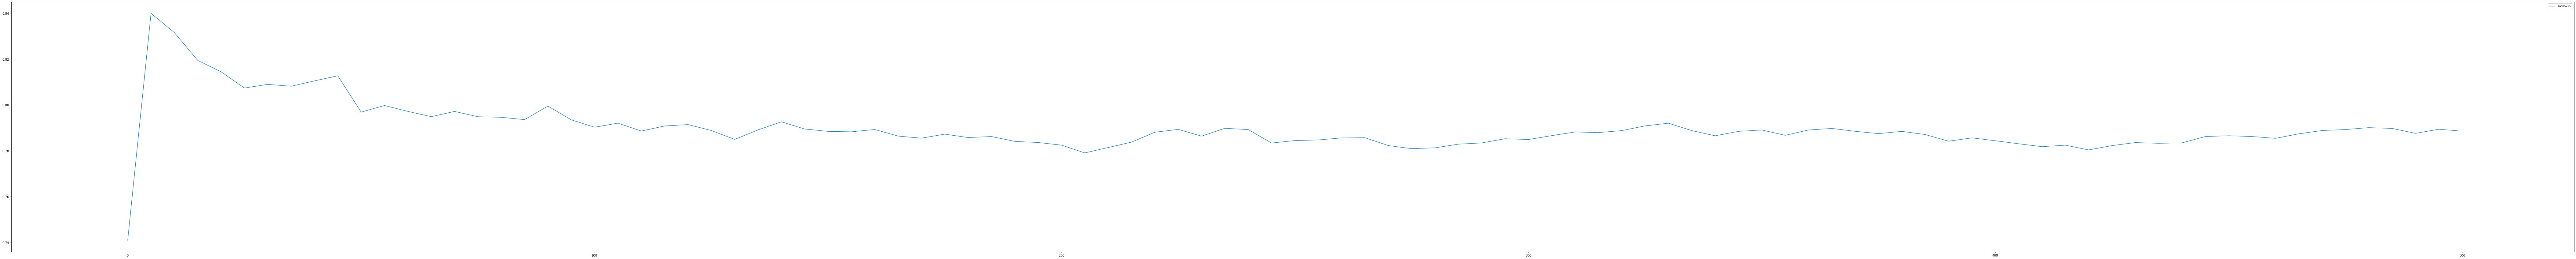

In [236]:
for mcw, df_score in scores3.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=mcw)

plt.legend()


In [204]:
# best mcw is 10
#(on 500 boost round)

xgb_params = {
    'eta': 0.05, 
    'max_depth': 2,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)



[0]	train-auc:0.82457	val-auc:0.77763
[5]	train-auc:0.83412	val-auc:0.78397
[10]	train-auc:0.83468	val-auc:0.78650
[15]	train-auc:0.84157	val-auc:0.79236
[20]	train-auc:0.84313	val-auc:0.79712
[25]	train-auc:0.84544	val-auc:0.79599
[30]	train-auc:0.84559	val-auc:0.79633
[35]	train-auc:0.84571	val-auc:0.79597
[40]	train-auc:0.84582	val-auc:0.79551
[45]	train-auc:0.85222	val-auc:0.82083
[50]	train-auc:0.85341	val-auc:0.82093
[55]	train-auc:0.85354	val-auc:0.82136
[60]	train-auc:0.85528	val-auc:0.82348
[65]	train-auc:0.85619	val-auc:0.82506
[70]	train-auc:0.85748	val-auc:0.82547
[75]	train-auc:0.85758	val-auc:0.82566
[80]	train-auc:0.85787	val-auc:0.82537
[85]	train-auc:0.85930	val-auc:0.82903
[90]	train-auc:0.85967	val-auc:0.82795
[95]	train-auc:0.86007	val-auc:0.82738
[100]	train-auc:0.86168	val-auc:0.82834
[105]	train-auc:0.86324	val-auc:0.82843
[110]	train-auc:0.86634	val-auc:0.83162
[115]	train-auc:0.86893	val-auc:0.83408
[120]	train-auc:0.87087	val-auc:0.83478
[125]	train-auc:0.8727

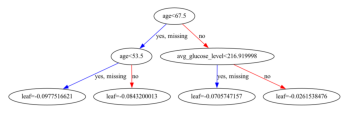

In [176]:
import matplotlib.pyplot as plt

#let's visualize how the XGBoost tree is made.
#we use some functions of the xgb library.
# [I also pip installed graphviz
# and brew it.]

xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [150,200]
plt.show()

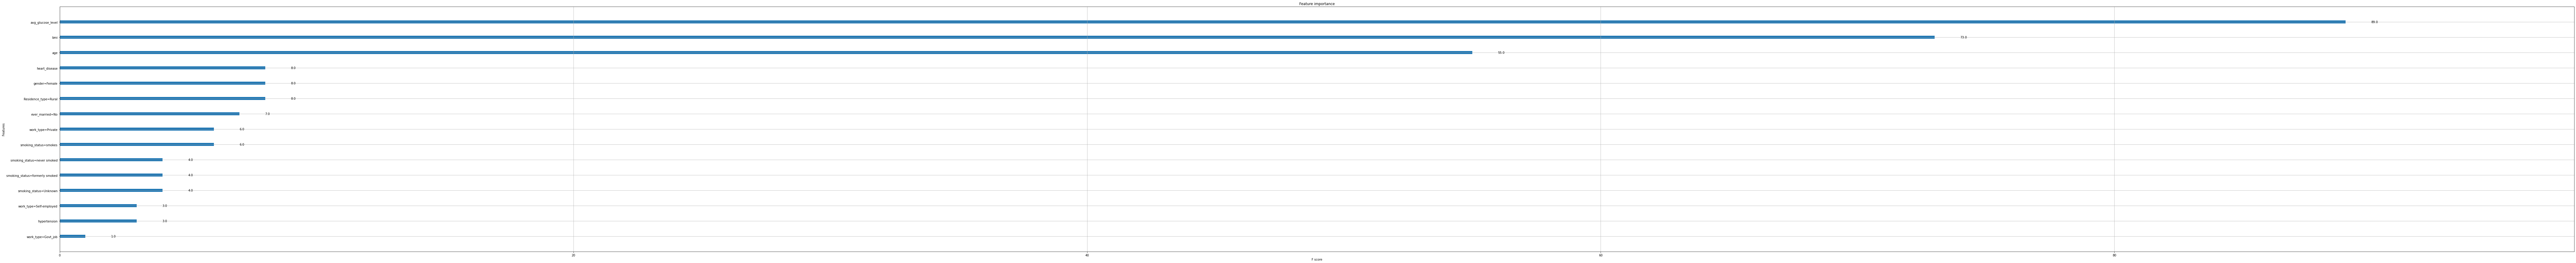

In [202]:
#feature importance
#this counts the number of nodes where a feature appears.
#the more it appears, the more likely is that it is an important criteria in the decision tree.
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [150, 15]
plt.show()

error=0.059687
=== MODEL PRED ===
43
1022
4.207436399217221
=== TRAIN DATA ===
143
3066
4.664057403783431


<AxesSubplot:ylabel='Count'>

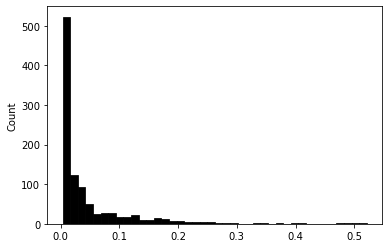

In [248]:
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)


preds = model.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)


print('=== MODEL PRED ===')
quanti_HS = sum(preds>0.20)
print(quanti_HS)

tot_preds = len(preds)
print(tot_preds)

share = quanti_HS / tot_preds
print(share*100)

print('=== TRAIN DATA ===')

quanti_HS_train = sum(y_train>0.5)
print(quanti_HS_train)

tot_train = len(y_train)
print(tot_train)

share_train = quanti_HS_train / tot_train
print(share_train*100)




plt.figure(figsize=(6, 4))

sns.histplot(preds, bins=40, color='black', alpha=1)


#final AUC confrontation:
#Logistic regression: 0.834

#RandomForest 0.81695

#XGBoost 0.838


#the best model is XGBoost
#tuned with:
# iterations = 500
# eta = 0.05
# max_depth = 2
# min_child_weight = 10



In [212]:
model.get_score(fmap='', importance_type='weight')


{'Residence_type=Rural': 1.0,
 'age': 405.0,
 'avg_glucose_level': 405.0,
 'bmi': 410.0,
 'ever_married=No': 16.0,
 'gender=Female': 23.0,
 'heart_disease': 23.0,
 'hypertension': 14.0,
 'smoking_status=formerly smoked': 2.0,
 'smoking_status=never smoked': 28.0,
 'smoking_status=smokes': 16.0,
 'work_type=Private': 17.0,
 'work_type=Self-employed': 3.0}

In [239]:
#mean, min and max value for output

mean_train = y_train.mean()
min_train = y_train.min()
max_train = y_train.max() 

mean_pred = preds.mean()
min_pred = preds.min()
max_pred = preds.max()

print("== TRAINING DATA ==")
print(mean_train)
print(min_train)
print(max_train)

print("== PREDICTION DATA ==")
print(mean)
print(min)
print(max)


== TRAINING DATA ==
0.04664057403783431
0
1
== PREDICTION DATA ==
0.046481274
0.0011078311
0.65565515
